![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 1. Emotion Classifier from scratch using Keras: Intro

We are going to train an Emotion Classifier from scratch using Keras on the Kaggle FER-2013 (Facial Emotion Recognition) Dataset.

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 2. Dataset

[Kaggle FER-2013 dataset](https://www.kaggle.com/datasets/msambare/fer2013) consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the test set consists of 3,589 examples.

The dataset has got lots of challenges that needs to be addressed:
- 1st challenge: Learning from a big image is easier compared to learning from a small image (48x48 pixels)
- 2nd challenge: We have many classes
- 3rd challenge: We have less no of images per class
- 4th challenge: Dataset is highly imbalanced (Train set has got 400+ images for 'disgust' class while 7200+ for 'happy' class)

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 3. Load Kaggle Dataset in Google Colab

In [1]:
# Install Kaggle
!pip3 install kaggle

In [2]:
# Upload Kaggle API key (kaggle.json file downloaded from your Kaggle account)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ancilcleetus","key":"21c225043e2abdc810ba33e0243b41e6"}'}

In [3]:
# Move kaggle.json file to .kaggle folder in home directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# Check the permission of the file
!ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 68 May 29 10:21 /root/.kaggle/kaggle.json


In [4]:
# Get Kaggle FER-2013 Dataset API Command & Download dataset
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 88% 53.0M/60.3M [00:00<00:00, 202MB/s]
100% 60.3M/60.3M [00:00<00:00, 191MB/s]


In [5]:
# Extract dataset zip file
from zipfile import ZipFile
file_name = "fer2013.zip"

with ZipFile(file_name, 'r') as zip_file:
  zip_file.extractall()
  print("Done")

Done


![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 4. Installing the required libraries

In [6]:
!pip3 install tensorflow keras numpy matplotlib opencv-python

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 5. Importing packages

In [7]:
import os
import random

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.applications import VGG16, ResNet50V2
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 6. Create Project Directory Structure to save models

In [8]:
# Define your project name
project_name = 'FER_2013_Emotion_Classifier'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Classifier


![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 7. Data Cleaning: Removing corrupted images

We will not be performing this step.

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 8. Data Analysis

In [9]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis
    # The index of the DataFrame is set to the provided set name
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  happy  fear  angry  disgust  neutral  surprise
train  4830   7215  4097   3995      436     4965      3171
       sad  happy  fear  angry  disgust  neutral  surprise
test  1247   1774  1024    958      111     1233       831


<Axes: >

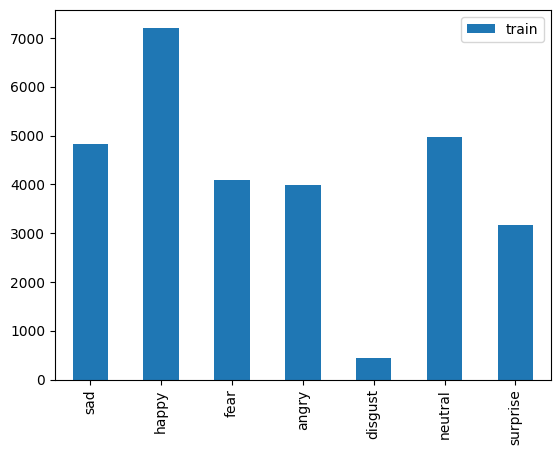

In [10]:
train_count.transpose().plot(kind='bar')

<Axes: >

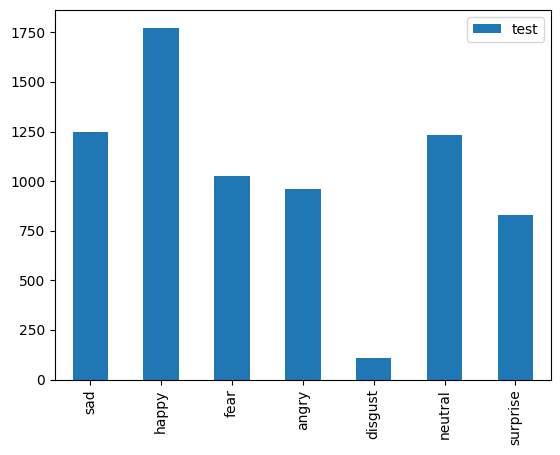

In [11]:
test_count.transpose().plot(kind='bar')

In the Training dataset, `disgust` class has got very few images (400+) while `happy` class has got very high number of images (7200+). Hence, model will learn more things about `happy` people while learning very less about `disgust` people. This is not what we want. This problem is called Class Imbalance.

In this scenario, we cannot rely solely on Accuracy metric since it tells only about the overall accuracy and does not account for the distribution of classes. In an imbalanced dataset, a model might achieve high accuracy by correctly predicting the majority class while poorly predicting the minority classes.

To evaluate the performance of our model more comprehensively, we can use Precision, Recall and F1-Score metrics.
- Precision (Positive Predictive Value):

    - The proportion of true positive predictions among all positive predictions. Useful when the cost of false positives is high.
    - Precision is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives).
    - Precision = TP/(TP + FP) where
        - TP = True Positives (correctly predicted positive instances)
        - FP = False Positives (incorrectly predicted positive instances)
- Recall (Sensitivity or True Positive Rate):
    
    - The proportion of true positive predictions among all actual positives. Important when the cost of false negatives is high.
    - Recall is the ratio of true positive predictions to the total number of actual positives (true positives + false negatives).
    - Recall = TP/(TP + FN) where
        - TP = True Positives (correctly predicted positive instances)
        - FN = False Negatives (actual positive instances that were incorrectly predicted as negative)
- F1-Score

    - The harmonic mean of precision and recall. It provides a single metric that balances both concerns.
    - F1-Score = 2 x Precision x Recall/(Precision + Recall)

These metrics can be calculated for each class in a multiclass classification problem and then averaged to get overall performance metrics (using methods such as macro, micro or weighted averages):

- Macro Average: Calculates metrics for each class independently and then takes the average. Treats all classes equally.
- Micro Average: Aggregates the contributions of all classes to compute the average metric. Gives more weight to the majority class.
- Weighted Average: Calculates metrics for each class and averages them, weighted by the number of true instances for each class. This accounts for class imbalance.

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 9. Plotting images from dataset

If we don't understand what our data looks like, we cannot build a good AI model. Hence, we plot some sample images from the dataset.

## 1. Plotting one image from each emotion folder

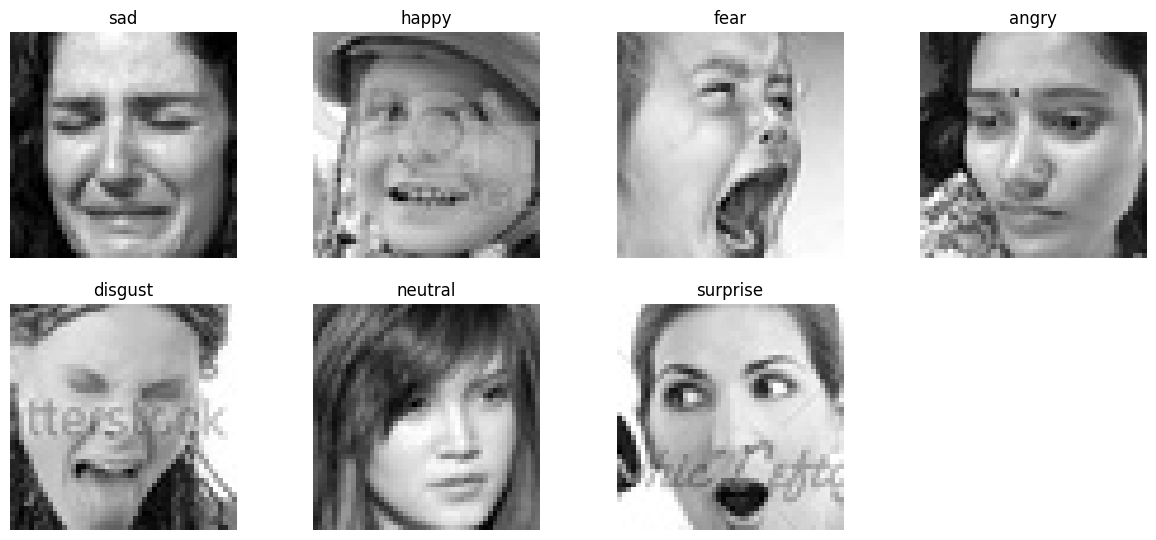

In [12]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## 2. Plotting random images from given emotion folder

In [13]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

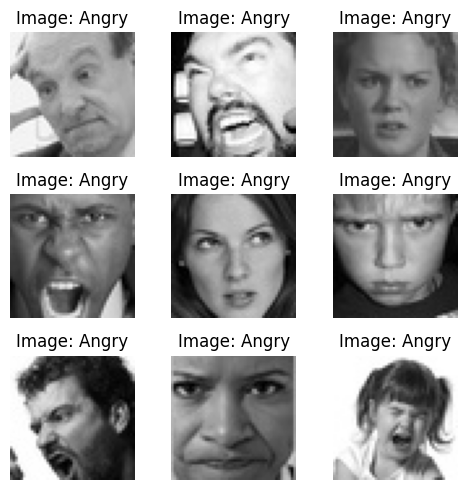

In [14]:
# Plot random images from angry folder
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

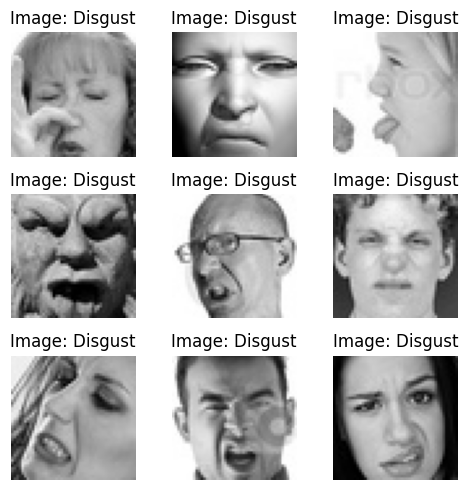

In [15]:
# Plot random images from disgust folder
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

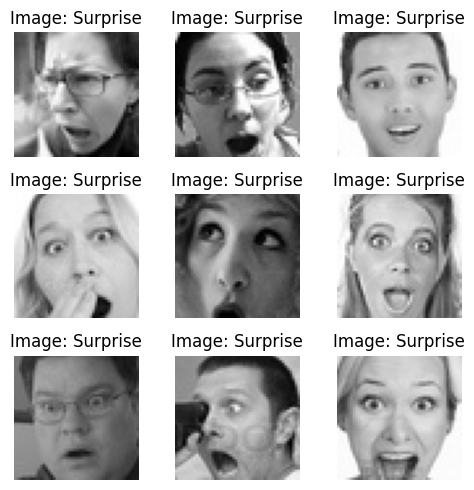

In [16]:
# Plot random images from surprise folder
surprise_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surprise_directory_path, class_name = 'Surprise')

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 10. Checking image shapes and channels

In [17]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image)  # Even though our images are grayscale, OpenCV by default loads in color format.

# If the image is loaded successfully, print its shape
if img is not None:
    print("Image shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Image shape: (48, 48, 3)


We need to load our images are grayscale itself, not as RGB. Hence, we use `cv2.IMREAD_GRAYSCALE` flag. This is a flag used in the OpenCV library to load an image in grayscale mode. When you use this flag with the `cv2.imread` function, it reads the image as a single-channel grayscale image, regardless of whether the original image is colored or not.

In [18]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its shape
if img is not None:
    print("Image shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Image shape: (48, 48)


![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 11. Model 1 : Custom CNN from Scratch

## 1. Data Loading: Load Images using `Keras ImageDataGenerator`

Lets say we have 10000 images of 5 MB each in our dataset. Let our machine has a GPU with 5 GB memory. Since 10000 $\times$ 5 MB = 50 GB > 5 GB, we cannot load all images at once. Hence, we use generators to load images in batches. Lets say we use a batch size of 100. Then, generators load 10000 images in 100 batches of 100 images each. Since 100 $\times$ 5 MB = 0.5 GB < 5 GB, this is feasible.

Here, we use [`Keras ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for loading images in batches. Since our images are inside a directory, we use `flow_from_directory` method of `Keras ImageDataGenerator` to create `train_generator`, `validation_generator` and `test_generator`.

In [19]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [20]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64  # Can adjust based on your memory constraints
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [21]:
# All pixel values will be rescaled by 1./255 (convert pixel values from [0, 255] to [0, 1]), 20% of data for validation
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Since Multi-class Classification (Use 'binary' for Binary Classification)
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 2. Getting Class Labels

We need to know the class labels assigned to various emotions by the `Keras ImageDataGenerator`.

In [22]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print(f"Training class labels: {train_class_labels}")

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print(f"Validation class labels: {validation_class_labels}")

# Accessing class labels for the test data
test_class_labels = test_generator.class_indices
print(f"Test class labels: {test_class_labels}")

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## 3. Building Model

In [23]:
# Initialize the CNN
model = Sequential()

# CNN portion of the model responsible for feature extraction
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# MLP (Multi-Layer Perceptron) portion of the model responsible for classification
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))  # Softmax activation for Multi-class Classification

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

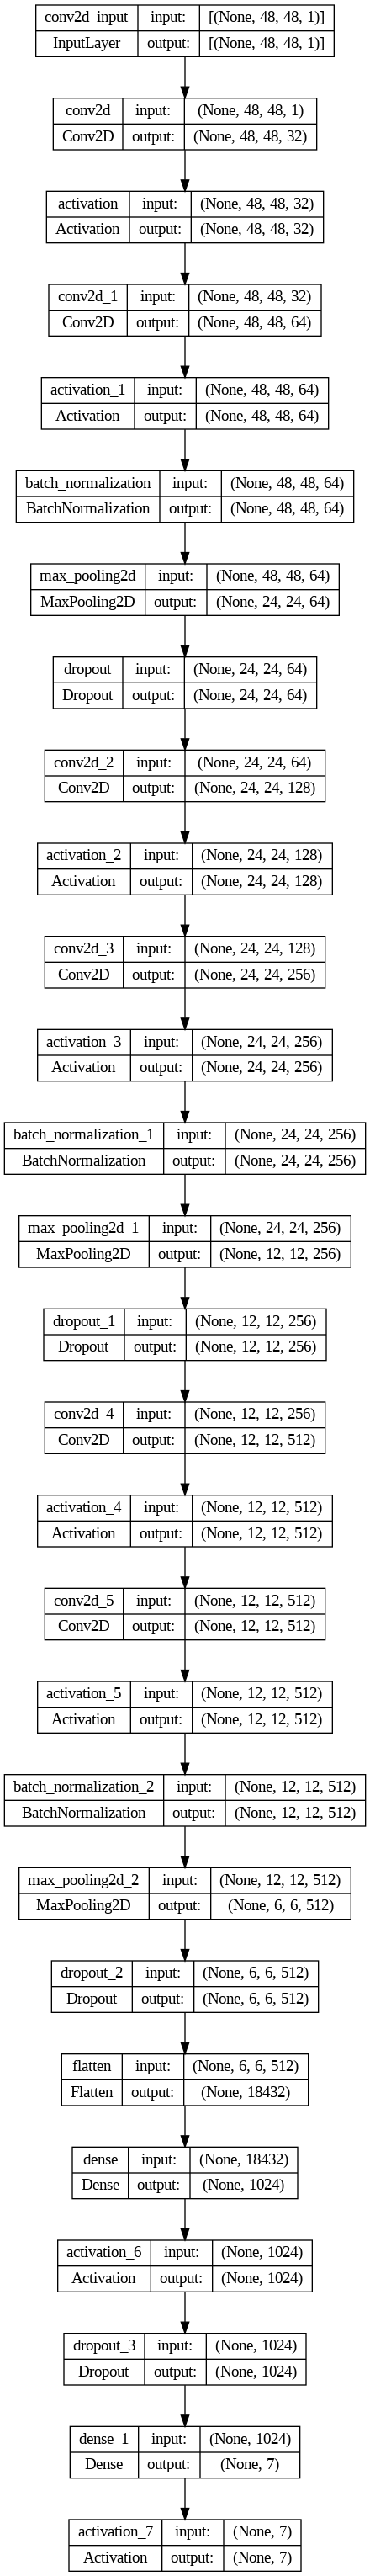

In [25]:
plot_model(model, to_file ='/content/FER_2013_Emotion_Classifier/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

**Note 1**

During training, we will be supplying the model with a single batch of data at a time. Hence, `None` in the above output shapes will be replaced with the `batch_size` of the data loader (i.e. `Keras ImageDataGenerator`).

**Note 2**

No of parameters for each layer is calculated as below:

- No of parameters in conv2d layer = $(3 \times 3 \times 3 + 1) \times 32 = 896$
- No of parameters in conv2d_1 layer = $(3 \times 3 \times 32 + 1) \times 64 = 18496$
- No of parameters in conv2d_2 layer = $(3 \times 3 \times 64 + 1) \times 128 = 73856$
- No of parameters in conv2d_3 layer = $(3 \times 3 \times 128 + 1) \times 128 = 147584$
- No of parameters in dense layer = $(6272 \times 512 + 512) = 3211776$
- No of parameters in dense_1 layer = $(512 \times 1 + 1) = 513$

In [ ]:
# Deep Learning as subset of ML

from IPython import display
display.Image("data/images/DL_01_Intro-01-DL-subset-of-ML.jpg")

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)